In [1]:
# import the necessary packages
%matplotlib inline

from pyimagesearch.transform import four_point_transform, order_points
from pyimagesearch import imutils
from skimage.filters import threshold_adaptive
import numpy as np
import argparse

import math
import cv2

import matplotlib.pyplot as plt
from IPython.display import display, Image
from glob import glob

#import pyimagesearch.transform
from pyimagesearch import imutils
from skimage.filters import threshold_adaptive

import datetime

def showImg(img, size=0, color=cv2.COLOR_BGR2RGB):
    rgb_img = cv2.cvtColor(img, color)
    if (size != 0):
        width = size
        height = size
        plt.figure(figsize=(size, size))
        plt.imshow(rgb_img)
    else:
        plt.figure()
        plt.imshow(rgb_img)
    

In [2]:
def mask_for_blue(frame):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([135,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    new_mask = cv2.GaussianBlur(mask, (9, 9),3)
    new_mask = cv2.inRange(new_mask, 200, 255)

    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(frame,frame, mask= mask)

    #cv2.imshow('frame',frame)
    #cv2.imshow('mask',mask)
    #cv2.imshow('res',res)
    #k = cv2.waitKey(50) & 0xFF 
    #if k == 27:
    #    cv2.destroyAllWindows()
    #    cv2.waitKey(1)
    #cv2.waitKey(1)
    return res, new_mask

In [3]:
def blob_detector_ex (img):

    # Read image
    #im = cv2.imread("blob.jpg")
    im = img
    im = cv2.GaussianBlur(im, (3, 3),1)
    
    # Set up the SimpleBlobdetector with default parameters.
    params = cv2.SimpleBlobDetector_Params()
     
    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 256;
     
    # Filter by Area.
    params.filterByArea = True
    params.minArea = 50
     
    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1
     
    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.5
     
    # Filter by Inertia
    params.filterByInertia =False
    params.minInertiaRatio = 0.5
    
    # Set up the detector with set parameters.
    detector = cv2.SimpleBlobDetector_create(params)
     
    # Detect blobs.
    reversemask = 255 - im
    keypoints = detector.detect(reversemask)
     
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), 
                                           cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    
    # Show keypoints
    #cv2.imshow("Keypoints", im_with_keypoints)
    #if cv2.waitKey(1) == 27:
    #    cv2.destroyAllWindows()
    #    cv2.waitKey(1)
        
    return keypoints, im_with_keypoints

In [ ]:
def snapshots():
    cam = cv2.VideoCapture(0)
    cv2.namedWindow("test")
    img_counter = 0
    
    images = []
    while True:
        ret, frame = cam.read()
        cv2.imshow("test", frame)
        if not ret:
            break
        k = cv2.waitKey(1)
    
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            
            break
            
        elif k%256 == 32:
            # SPACE pressed
            img_name = "opencv_frame_{}.png".format(img_counter)
            
            text = "{} written!".format(img_name)
            fontFace = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX;
            fontScale = 2;
            thickness = 3;
            
            #cv2.putText("test", text, (0,0), fontFace, fontScale, thickness)
            cv2.imwrite(img_name, frame)
            images.append(frame)
            
            print("{} written!".format(img_name))
            img_counter += 1
    
    cam.release()
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return images

In [ ]:
images = snapshots()
showImg(images[0], 12)

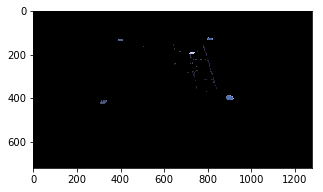

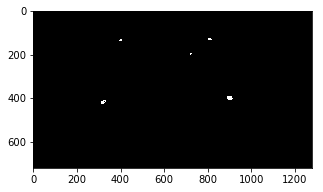

In [4]:
frame = cv2.imread("opencv_frame_0.png")
res, mask = mask_for_blue(frame)
showImg(res, 5)
showImg(mask, 5, cv2.COLOR_GRAY2RGB)


720


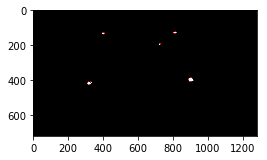

In [5]:
keypoints, im_with_keypoints = blob_detector_ex(mask)
showImg(im_with_keypoints, 4)

print(im_with_keypoints.shape[0])

pt_list = [keypoint.pt for keypoint in keypoints]
pts = np.asarray(pt_list)
#print(pts)

579 579


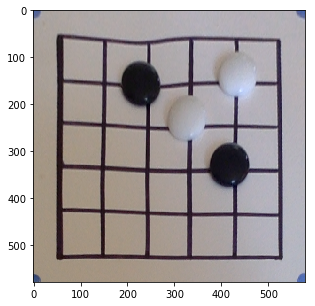

In [6]:
# perfrom scanner transform
warped = four_point_transform(frame,pts,True)

cv2.imwrite('warped.png', warped)
showImg(warped, 5)

In [7]:
def crop(img, top, left, bot=-1, right=-1):
    if (bot == -1):
        bot = top
    if (right == -1):
        right = left
        
    height = img.shape[0] #height
    width = img.shape[1]
    return img[top:(height - bot), left:(width - right)]

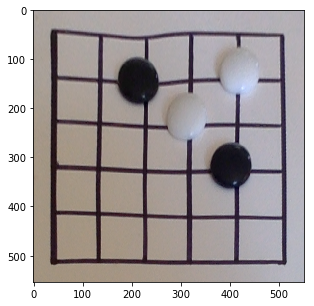

In [8]:
cropped = crop(warped, 13, 15, 12, 12)
showImg(cropped, 5)

529 529


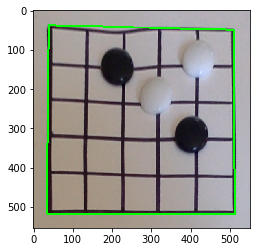

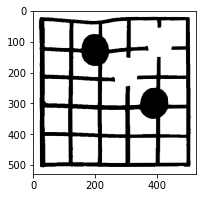

In [9]:
gray = cv2.cvtColor(cropped,cv2.COLOR_BGR2GRAY)
gray = cv2.inRange(gray, 105, 255)

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(gray,kernel,iterations = 1)
gray = cv2.GaussianBlur(erosion, (5, 5),0)

#showImg(gray,4,cv2.COLOR_GRAY2RGB)


im2, contours, hierarchy = cv2.findContours(gray.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

c = cnts[1]
peri = cv2.arcLength(c, True)
approx = cv2.approxPolyDP(c, 0.10 * peri, True)


im_cnts2 = cropped.copy()
blah2 = cv2.drawContours(im_cnts2, [approx], -1, (0,255,0), 3)
showImg(blah2)

approx.resize(4,2)
rect = order_points(approx) # UL, UR, BR, BL

def expand_rect(p, rect):
    rect[0]    -= p
    rect[1][0] += p
    rect[1][1] -= p
    rect[2]    += p
    rect[3][0] -= p
    rect[3][1] += p 
    return rect

#print((rect[1][0] - rect[0][0])/ 6)
expand_rect(25, rect)
warped_gray = four_point_transform(gray,rect,True)

showImg(warped_gray, 3, cv2.COLOR_GRAY2RGB)
#print(len(contours))
#print(type(cnts[1]))
#
#im_cnts = cropped.copy()
#blah = cv2.drawContours(im_cnts, cnts, 1, (0,255,0), 3)
#showImg(blah)

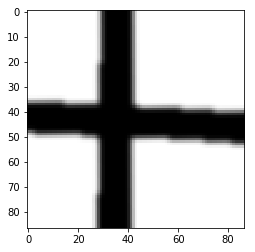

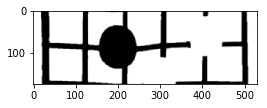

In [10]:
## slice to center on crosses, find circles
#showImg(gray,4,cv2.COLOR_GRAY2RGB)
dist = int((rect[1][0] - rect[0][0])/ 6)
showImg(warped_gray[2 * dist: 3 * dist,1 * dist: 2 * dist], 4, cv2.COLOR_GRAY2RGB)
showImg(warped_gray[1 * dist - int(dist/2) : 2 * dist + int(dist/2),], 4, cv2.COLOR_GRAY2RGB)

copy = warped_gray[1 * dist - int(dist/2) : 2 * dist + int(dist/2),].copy()
# detect circles in the image
circles = cv2.HoughCircles(copy, cv2.HOUGH_GRADIENT, 1.2, 100)
 
# ensure at least some circles were found
if circles is not None:
	print("not none")
    # convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
 
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
 
	# show the output image
	cv2.imshow("output", np.hstack([image, output]))
	cv2.waitKey(0)

Outline of flow:
    setup camera
    take image
    identify blob coords
    pass coords to transform
    refine image 
        - 
    divide image into 13x13 (or 9x9, etc)
    determine if center is black, white or cross
    make matrix of -1,0,1 for black, none, white piece
    

In [ ]:
## saves 1 frame of video per second to imagesFolder
def down_sample_video(videoFile, imagesFolder="./images"):
    cap = cv2.VideoCapture(videoFile)
    frameRate = cap.get(5) #frame rate (or CAP_PROP_FPS)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0): #will happen once per second
            filename = imagesFolder + "/image_" +  str(int(frameId)) + ".jpg"
            cv2.imwrite(filename, frame)
    cap.release()
    print "Done!"

In [ ]:
# from GoScanner.py
# USAGE
# python goScanner.py --image images/page.jpg

# import the necessary packages
from pyimagesearch.transform import four_point_transform
from pyimagesearch import imutils
from skimage.filters import threshold_adaptive
import numpy as np
import argparse
import cv2



# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread(args["image"])
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the image to grayscale, blur it, and find edges
# in the image
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#gray = cv2.GaussianBlur(gray, (5, 5), 0)
#edged = cv2.Canny(gray, 75, 200)

# show the original image and the edge detected image
#print ("STEP 1: Edge Detection")
#cv2.imshow("Image", image)
#cv2.imshow("Edged", edged)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
#_2, cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

# loop over the contours
#for c in cnts:
#	# approximate the contour
#	peri = cv2.arcLength(c, True)
#	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
#
#	# if our approximated contour has four points, then we
#	# can assume that we have found our screen
#	if len(approx) == 4:
#		screenCnt = approx
#		break

# show the contour (outline) of the piece of paper
#print ("STEP 2: Find contours of paper")
#cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
#cv2.imshow("Outline", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

# apply the four point transform to obtain a top-down
# view of the original image
#warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#warped = threshold_adaptive(warped, 251, offset = 10)
#warped = warped.astype("uint8") * 255

# show the original and scanned images
#print ("STEP 3: Apply perspective transform")
#cv2.imshow("Original", imutils.resize(orig, height = 650))
#cv2.imshow("Scanned", imutils.resize(warped, height = 650))
#cv2.waitKey(0)

